<h1> Insurance Cost Predictor Using Regression


This project implements regression to build a model that predicts insurance costs for an individual.
<br>The dataset includes the following feature sets:
<ol>
<li>age (integer): Age of a person
<li>sex (categorical): Sex of the person
<li>bmi (float): Body Mass Index of a person
<li>children (integer): No, of children the person have
<li>smoker(categorical): Whether a person smokes or not
<li>region (categorical): The region person is from.
<li>charges (float): The insurance cost of the person.
</ol>
<br>In this project, five popular regression algorithms—<i>Multiple Linear Regression, Decision Tree Regression, Random Forest Regression, K-Nearest Neighbors Regression, and Support Vector Regression</i>—are fitted and tested on the dataset, with their accuracy metrics compared. The most accurate algorithm is then used for further predictions.

<i> Imports</i>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

Reading the dataset & printing head and tail

In [5]:
df=pd.read_csv("medical_insurance.csv")
print(df.head().to_string())
print(df.tail().to_string())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
      age     sex     bmi  children smoker     region      charges
2767   47  female  45.320         1     no  southeast   8569.86180
2768   21  female  34.600         0     no  southwest   2020.17700
2769   19    male  26.030         1    yes  northwest  16450.89470
2770   23    male  18.715         0     no  northwest  21595.38229
2771   54    male  31.600         0     no  southwest   9850.43200


Let's do some simple EDA on the dataset for proper understanding.

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
None


The dataset consists of 2772 columns out of which there are no null values. Also we can check the datatypes of all the columns.

In [7]:
print(df.describe())

               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010


Here we can observe the different range of values each column contains.

Checking for null values

In [8]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


There are no null values in the dataset.

Checking each categorical data for distribution.

In [9]:
for col in ['sex', 'smoker', 'region']:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("-" * 30)

Value counts for sex:
sex
male      1406
female    1366
Name: count, dtype: int64
------------------------------
Value counts for smoker:
smoker
no     2208
yes     564
Name: count, dtype: int64
------------------------------
Value counts for region:
region
southeast    766
southwest    684
northwest    664
northeast    658
Name: count, dtype: int64
------------------------------


Here we can see the distribution of categorical data, and except for smoking status, other 2 categorical data are evenly distributed.

Now we check for outliers in all the numeric columns(age, BMI, No. of Children')

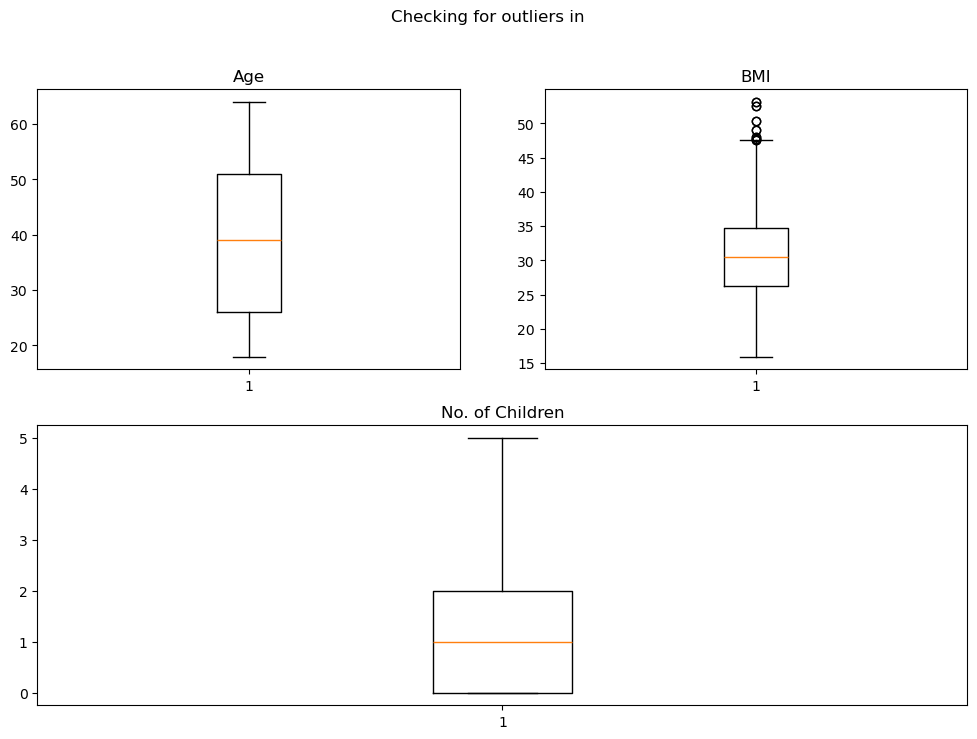

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.boxplot(data=df,x='age')
plt.title("Age")
plt.subplot(2,2,2)
plt.boxplot(data=df,x='bmi')
plt.title("BMI")
plt.subplot(2,2,(3,4))
plt.boxplot(data=df,x='children')
plt.title("No. of Children")
plt.suptitle("Checking for outliers in")
plt.show()

Outliers are found in the BMI column. Rows are dropped using the IQR rule

In [11]:
Q1=df['bmi'].quantile(0.25)
Q3=df['bmi'].quantile(0.75)

IQR=Q3-Q1
lower_bound= Q1-1.5*IQR
upper_bound= Q3+1.5*IQR
print(lower_bound,upper_bound)

df_filtered=df[(df['bmi']>=lower_bound) & (df['bmi']<47)] # upper bound = 47 removes all outliers in one step. If not, this whole step has to be
                                                          # repeated 2 or more times.
print(df_filtered.shape)
print(df.shape)

13.394999999999992 47.59500000000001
(2754, 7)
(2772, 7)


Dataset after dropping the outliers

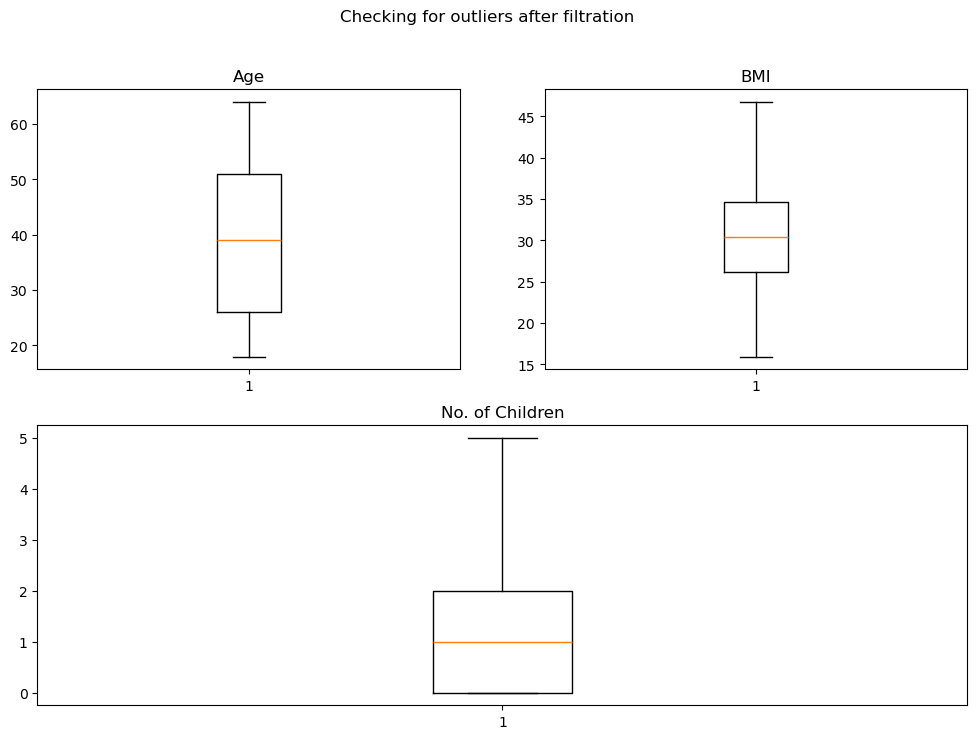

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.boxplot(data=df_filtered,x='age')
plt.title("Age")
plt.subplot(2,2,2)
plt.boxplot(data=df_filtered,x='bmi')
plt.title("BMI")
plt.subplot(2,2,(3,4))
plt.boxplot(data=df_filtered,x='children')
plt.title("No. of Children")
plt.suptitle("Checking for outliers after filtration")
plt.show()

In [13]:
df=df_filtered


Now we do a correlation analysis(Relationship of values of columns with any other columns.)

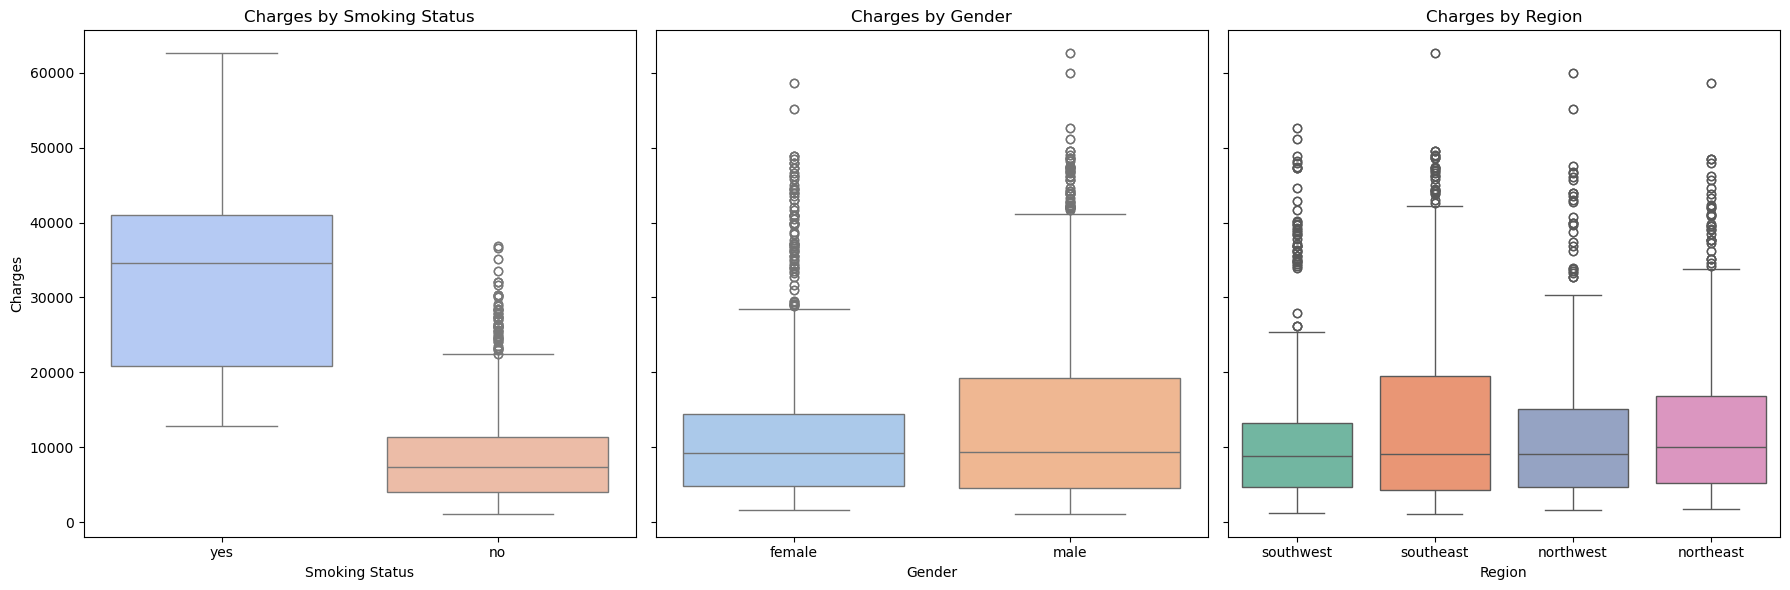

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.boxplot(ax=axes[0], data=df, x='smoker', y='charges', hue='smoker', palette="coolwarm", dodge=False)
axes[0].set_title("Charges by Smoking Status")
axes[0].set_xlabel("Smoking Status")
axes[0].set_ylabel("Charges")

sns.boxplot(ax=axes[1], data=df, x='sex', y='charges', hue='sex', palette="pastel", dodge=False)
axes[1].set_title("Charges by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("")


sns.boxplot(ax=axes[2], data=df, x='region', y='charges', hue='region', palette="Set2", dodge=False)
axes[2].set_title("Charges by Region")
axes[2].set_xlabel("Region")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

By infering this plot, we understand that main factor that affects insurance cost is 'smoker' status. i.e, smokers tend to have a higher insurance cost.

Now we check for correlation in the numerical columns.

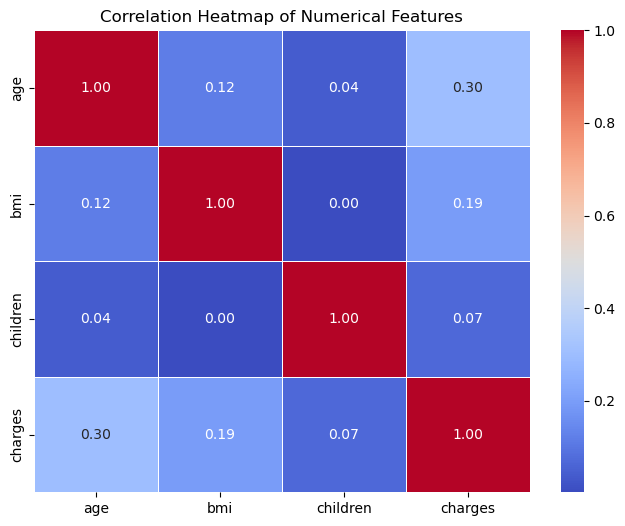

In [15]:
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix=numerical_columns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Here, from visualizing the correlation matrix, we can understand that highest correlation is found between the age and charges column. This means that as the age increases, the increase of insurance cost is higher than the other features.

Now we begine the Machine Learning Progarm

---

Splitting the features and target variable

In [16]:
x=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

print(x)
print(y)

[[19 'female' 27.9 0 'yes' 'southwest']
 [18 'male' 33.77 1 'no' 'southeast']
 [28 'male' 33.0 3 'no' 'southeast']
 ...
 [19 'male' 26.03 1 'yes' 'northwest']
 [23 'male' 18.715 0 'no' 'northwest']
 [54 'male' 31.6 0 'no' 'southwest']]
[16884.924    1725.5523   4449.462   ... 16450.8947  21595.38229
  9850.432  ]


Encoding the categorical values using LabelEncoder

In [17]:
labEnc_sex=LabelEncoder()
labEnc_smoker=LabelEncoder()
labEnc_region=LabelEncoder()
x[:, 1] = labEnc_sex.fit_transform(x[:, 1])  # Gender: Female 0, Male 1
x[:, 4] = labEnc_smoker.fit_transform(x[:, 4])  # Smoker: Yes 1, No 0
x[:, 5] = labEnc_region.fit_transform(x[:, 5])  # Region: Northeast 0, Northwest 1, Southeast 2, Southwest 3
print(x)

[[19 0 27.9 0 1 3]
 [18 1 33.77 1 0 2]
 [28 1 33.0 3 0 2]
 ...
 [19 1 26.03 1 1 1]
 [23 1 18.715 0 0 1]
 [54 1 31.6 0 0 3]]


Using ColumnTransformer to convert the categorical columns into multiple columns


In [18]:
ct=ColumnTransformer(
    transformers=[
        ('onehot',OneHotEncoder(drop='first'),[1,4,5]) # Dropping the dummy variable column(1st column after each transform) using drop='first'
    ],
    remainder='passthrough'
)

x=ct.fit_transform(x)
xdf=pd.DataFrame(x)
print(x[0])

[0.0 1.0 0.0 0.0 1.0 19 27.9 0]


Splitting the training data and test data and setting the random state

In [19]:
x_test,x_train,y_test,y_train=train_test_split(
    x,y,test_size=0.25,random_state=2
)

Scaling the x values for KNN and SVR algorithms.

In [20]:
ss_x = StandardScaler()
scaled_x_train = ss_x.fit_transform(x_train)
scaled_x_test = ss_x.transform(x_test)

Hyperparameter tuning for the algorithms

1. Linear Regression doesn't have hyperparameters, so tuning isn't required.

2. Decision Tree Regression

In [ ]:
dtr=DecisionTreeRegressor()
param_dtr= {
    'criterion': ['squared_error', 'absolute_error'], 
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None],  
    'splitter': ['best', 'random'],  
}
#  hyperparameter tuning

gridCLF=GridSearchCV(dtr,param_dtr,scoring='r2',cv=5, n_jobs=-1 )
gridCLF.fit(x_train,y_train)
print(gridCLF.best_params_)

# Results after the hyperparameter tuning:
# 'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'

3. Random Forest Regression

In [ ]:


rfr=RandomForestRegressor()
param_rfr = {
    'n_estimators': [100, 200],  
    'max_depth': [None, 10],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False], 
    'criterion': ['squared_error', 'absolute_error']  
}




gridCLF=GridSearchCV(rfr,param_rfr,scoring='r2',cv=5, n_jobs=-1 )
gridCLF.fit(x_train,y_train)
print(gridCLF.best_params_)
# Results after the hyperparameter tuning:
# {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

4. KNN Regression

In [ ]:
knn=KNeighborsRegressor()
param_knn={
    'n_neighbors': [3, 5, 7, 10, 15],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'leaf_size': [10, 20, 30]  
}

gridCLF=GridSearchCV(knn,param_knn,scoring='r2',cv=5, n_jobs=-1 )
gridCLF.fit(scaled_x_train,y_train)
print(gridCLF.best_params_)
# Results after the hyperparameter tuning:
# 'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'

5. SVR

In [ ]:
svr=SVR()
param_svr = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],  
    'degree': [3, 4, 5], 
    'gamma': ['scale', 'auto'],  
    'epsilon': [0.1, 0.2, 0.5] 
}


gridCLF=GridSearchCV(svr,param_svr,scoring='r2',cv=5, n_jobs=-1)
gridCLF.fit(scaled_x_train,y_train)
print(gridCLF.best_params_)
# Results after the hyperparameter tuning:
# 'C': 100, 'degree': 3, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'linear'

After hyperparameter tuning, the accuracies of all the algorithms improved, some of them being drastically better. Now we copy these hyperparameters into our model initialisation

Defining a function for model fitting, prediction and evaluation

In [25]:
def model_evaluation(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    r2 = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    return r2, mae, rmse


models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(criterion='squared_error', max_depth=10, max_features= None, min_samples_leaf= 4, min_samples_split= 10, splitter='best'),
    "Random Forest Regression": RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=200),
    "KNN Regression": KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='euclidean', n_neighbors=15, weights='distance'),
    "SVR Regression": SVR(C=100, degree=3, epsilon=0.5, gamma='scale', kernel='linear')
}

Printing out the results

In [26]:
results = []


for model_name, model in models.items():
    if model_name == "KNN Regression" or model_name == "SVR Regression":
        r2, mae, rmse = model_evaluation(model, scaled_x_train, scaled_x_test, y_train, y_test)
    else:
        r2, mae, rmse = model_evaluation(model, x_train, x_test, y_train, y_test)
    
    results.append({
        "Model": model_name,
        "R-squared": r2,
        "Mean Absolute Error": mae,
        "Root Mean Squared Error": rmse
    })


results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                   Model  R-squared  Mean Absolute Error  Root Mean Squared Error
       Linear Regression   0.757298          4177.024841              5941.226145
Decision Tree Regression   0.825764          2744.116498              5033.941165
Random Forest Regression   0.886558          1981.424818              4061.872187
          KNN Regression   0.820330          2653.711043              5111.840526
          SVR Regression   0.610101          3639.143964              7530.350450


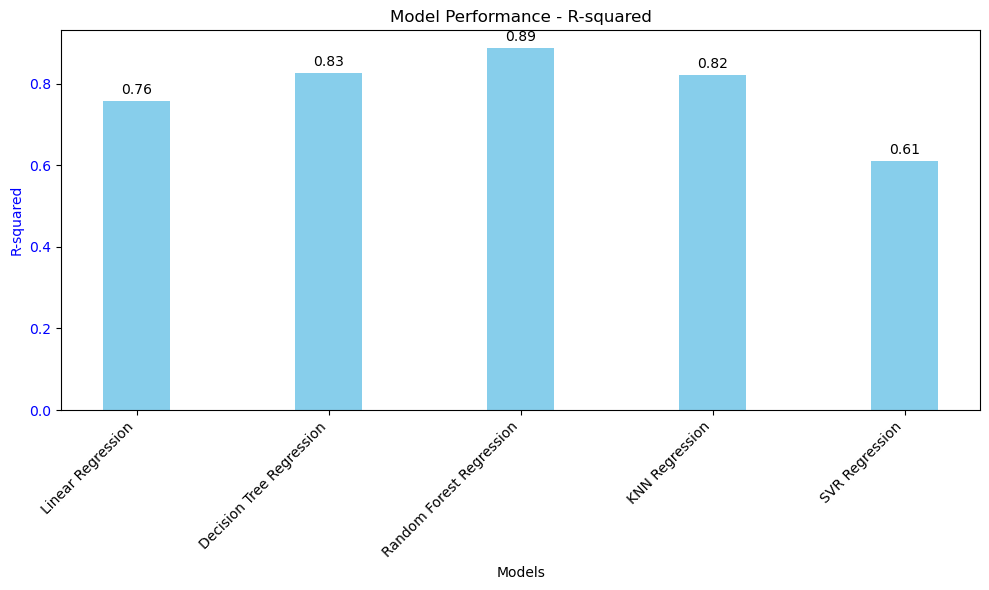

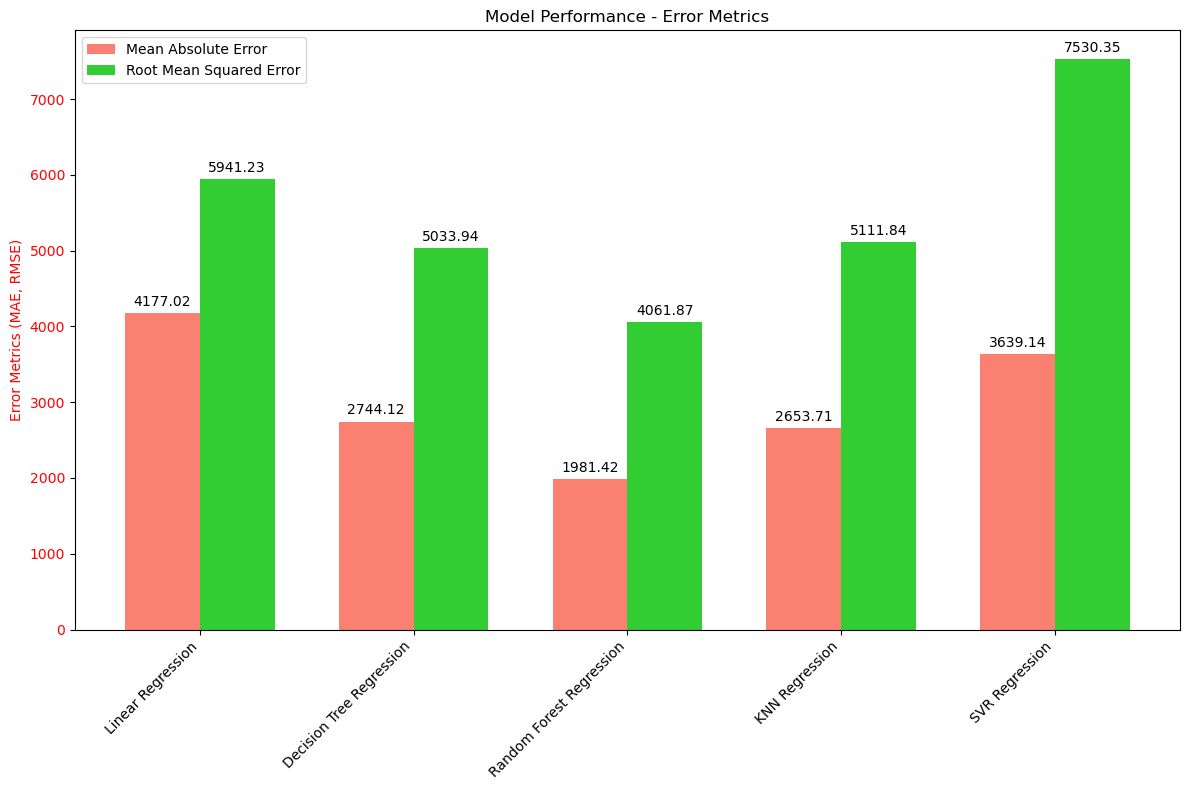

In [27]:

model_names = results_df['Model'] 
r2_values = results_df['R-squared']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

x = np.arange(len(model_names))  
width = 0.35  


fig, ax1 = plt.subplots(figsize=(10, 6))
bar_r2 = ax1.bar(x, r2_values, width, color='skyblue', label='R-squared')

ax1.set_title('Model Performance - R-squared')
ax1.set_xlabel('Models')
ax1.set_ylabel('R-squared', color='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='blue')


for bar in bar_r2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()

fig, ax2 = plt.subplots(figsize=(12, 8))
bar_mae = ax2.bar(x - width / 2, mae_values, width, label='Mean Absolute Error', color='salmon')
bar_rmse = ax2.bar(x + width / 2, rmse_values, width, label='Root Mean Squared Error', color='limegreen')


ax2.set_ylabel('Error Metrics (MAE, RMSE)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_title('Model Performance - Error Metrics')


for bars in [bar_mae, bar_rmse]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

ax2.legend()

plt.tight_layout()
plt.show()


From this results, we can observe that Random Forest Regression algorithm produces the best scores in accuracy and error measurements. So we will calculate the custom predictions using Random Forest Regression.

<b>For Reference:</b><br>
Gender: Female-0, Male-1<br>
Smoker: No-0, Yes-1<br>
Region: Northeast-0, Northwest-1, Southeast-2, Southwest-3

In-program custom input

In [28]:
x_custom = np.array([[23, 'male', 27.8, 0, 'yes', 'southeast']], dtype=object)

x_custom[:, 1] = labEnc_sex.transform(x_custom[:, 1])
x_custom[:, 4] = labEnc_smoker.transform(x_custom[:, 4])
x_custom[:, 5] = labEnc_region.transform(x_custom[:, 5])

x_custom = ct.transform(x_custom)
y_custom = models['Random Forest Regression'].predict(x_custom)

print("Custom input prediction:",y_custom[0].round(2))

Custom input prediction: 25202.37


Now we take user input and predict from it

In [ ]:
def get_input():
    age = int(input("Enter the age: "))
    bmi = float(input("Enter BMI: "))
    children = int(input("Enter no. of children: "))
    
    while True:
        print("\nSelect Gender")
        print("1: Female")
        print("2: Male")
        gender_choice = input("Enter either 1 or 2: ")
        if gender_choice == '1':
            gender = 'female'
            break
        elif gender_choice == '2':
            gender = 'male'
            break
        else:
            print("Invalid input. Please enter 1 for Female or 2 for Male.")

    while True:
        print("\nAre you a smoker?")
        print("1: Yes")
        print("2: No")
        smoker_choice = input("Enter 1 for Yes or 2 for No: ")
        if smoker_choice == '1':
            smoker = 'yes'
            break
        elif smoker_choice == '2':
            smoker = 'no'
            break
        else:
            print("Invalid input. Please enter 1 for Yes or 2 for No.")
    
    while True:
        print("\nSelect region:")
        print("1: Northeast")
        print("2: Northwest")
        print("3: Southeast")
        print("4: Southwest")
        region_choice = input("Enter 1, 2, 3, or 4 for the corresponding region: ")
        if region_choice == '1':
            region = 'northeast'
            break
        elif region_choice == '2':
            region = 'northwest'
            break
        elif region_choice == '3':
            region = 'southeast'
            break
        elif region_choice == '4':
            region = 'southwest'
            break
        else:
            print("Invalid input. Please enter a number from 1 to 4 for the region.")

    return np.array([[age, gender, bmi, children, smoker, region]], dtype=object)

x_user = get_input()
cols=['Age','Gender','BMI','No. of Children','Smoker','Region']
userDF=pd.DataFrame(x_user,columns=cols)
print('\nUser Input Data\n',userDF.to_string(index=False))




Select Gender
1: Female
2: Male

Are you a smoker?
1: Yes
2: No

Select region:
1: Northeast
2: Northwest
3: Southeast
4: Southwest

User Input Data Age Gender   BMI No. of Children Smoker    Region
 23 female  28.0               0     no southeast


In [30]:
x_user[:,1]=labEnc_sex.transform(x_user[:,1])
x_user[:,4]=labEnc_smoker.transform(x_user[:,4])
x_user[:,5]=labEnc_region.transform(x_user[:,5])
x_user=ct.transform(x_user)
y_user=models['Random Forest Regression'].predict(x_user)
print("Insurance cost prediction for user input data is:",y_user[0].round(2))

Insurance cost prediction for user input data is: 4553.27


# Conclusion
This project implemented some popular regression models to determine the most effective algorithm for predicting insurance costs based on the given data. By comparing accuracy scores and error metrics, the project identified the Random Forest Regression algorithm as the most suitable model for this dataset. Random Forest Regression was ultimately used to predict insurance costs for both sample input data and custom user input.